In [23]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
import os
from datetime import datetime
from collections import defaultdict
import bisect
from matplotlib.ticker import MaxNLocator
from matplotlib import pyplot as plt
from math import sqrt

In [2]:
path = 'FBL_object5/'
sorted(os.listdir(path))

['afbl_f_d_test.csv',
 'afbl_f_d_train.csv',
 'afbl_x1_d_test.csv',
 'afbl_x1_d_train.csv',
 'afbl_x2_d_test.csv',
 'afbl_x2_d_train.csv']

In [4]:
X1_train = pd.read_csv(path+'afbl_x1_d_train.csv')
X2_train = pd.read_csv(path+'afbl_x2_d_train.csv')
X1_test = pd.read_csv(path+'afbl_x1_d_test.csv')
X2_test = pd.read_csv(path+'afbl_x2_d_test.csv')

Y_train = pd.read_csv(path+'afbl_f_d_train.csv')
Y_test = pd.read_csv(path+'afbl_f_d_test.csv')

X1_train.shape, Y_train.shape, X2_test.shape

((25542, 1), (25542, 1), (149128, 1))

In [9]:
x_train = np.array(pd.concat((X1_train,X2_train),axis=1))
x_test = np.array(pd.concat((X1_test,X2_test),axis=1))
y_train,y_test = np.array(Y_train),np.array(Y_test)
print(x_train.shape,x_test.shape,y_train.shape,y_test.shape)

(25542, 2) (149128, 2) (25542, 1) (149128, 1)


In [12]:
from scipy import *
from scipy.linalg import norm, pinv
import math
 
from matplotlib import pyplot as plt
 
class RBF:
     
    def __init__(self, indim, numCenters, outdim):
        self.indim = indim
        self.outdim = outdim
        self.numCenters = numCenters
        self.centers = [np.random.uniform(-1, 1, indim) for i in range(numCenters)]
        self.beta = 8
        self.W = np.random.random((self.numCenters, self.outdim))
         
    def _basisfunc(self, c, d):
        assert len(d) == self.indim
        return norm(c-d)**3
     
    def _calcAct(self, X):
        # calculate activations of RBFs
        G = np.zeros((X.shape[0], self.numCenters), float)
        for ci, c in enumerate(self.centers):
            for xi, x in enumerate(X):
                G[xi,ci] = self._basisfunc(c, x)
        return G
     
    def train(self, X, Y):
        """ X: matrix of dimensions n x indim 
            y: column vector of dimension n x 1 """
         
        # choose random center vectors from training set
        rnd_idx = np.random.permutation(X.shape[0])[:self.numCenters]
        self.centers = [X[i,:] for i in rnd_idx]
         
        #print("center", self.centers)
        # calculate activations of RBFs
        G = self._calcAct(X)
        #print(G)
         
        # calculate output weights (pseudoinverse)
        self.W = np.dot(pinv(G), Y)
         
    def test(self, X):
        """ X: matrix of dimensions n x indim """
         
        G = self._calcAct(X)
        Y = np.dot(G, self.W)
        return Y

In [13]:
t1 = datetime.now()

rbf = RBF(2,100, 1)
rbf.train(x_train, y_train)
t2 = datetime.now()

In [14]:
y1 = rbf.test(x_test)
print('time taken by FBL:', t2-t1)
print('Root Mean Squared error: ', mean_squared_error(y_test,y1)**0.5)

time taken by FBL: 0:01:09.307116
Root Mean Squared error:  0.07159972513127309


# CATBOOST MODEL

In [18]:
from catboost import CatBoostRegressor
cat = CatBoostRegressor()
t1 = datetime.now()
cat.fit(x_train,y_train)
t2 = datetime.now()

Learning rate set to 0.068317
0:	learn: 1.1220040	total: 63.3ms	remaining: 1m 3s
1:	learn: 1.0506472	total: 87.5ms	remaining: 43.7s
2:	learn: 0.9830517	total: 135ms	remaining: 44.7s
3:	learn: 0.9214165	total: 188ms	remaining: 46.9s
4:	learn: 0.8630876	total: 194ms	remaining: 38.5s
5:	learn: 0.8094517	total: 199ms	remaining: 32.9s
6:	learn: 0.7586896	total: 206ms	remaining: 29.2s
7:	learn: 0.7108397	total: 238ms	remaining: 29.5s
8:	learn: 0.6664471	total: 244ms	remaining: 26.8s
9:	learn: 0.6252585	total: 255ms	remaining: 25.2s
10:	learn: 0.5859947	total: 330ms	remaining: 29.6s
11:	learn: 0.5497770	total: 349ms	remaining: 28.7s
12:	learn: 0.5160618	total: 411ms	remaining: 31.2s
13:	learn: 0.4846254	total: 446ms	remaining: 31.4s
14:	learn: 0.4553388	total: 452ms	remaining: 29.7s
15:	learn: 0.4276193	total: 532ms	remaining: 32.7s
16:	learn: 0.4020631	total: 555ms	remaining: 32.1s
17:	learn: 0.3783948	total: 573ms	remaining: 31.2s
18:	learn: 0.3566305	total: 617ms	remaining: 31.9s
19:	learn

In [19]:
y2 = cat.predict(x_test)
print('time taken by Catboost on FBL data:', t2-t1)
print('Root Mean Squared error: ', mean_squared_error(y_test,y2)**0.5)

time taken by Catboost on FBL data: 0:00:27.906674
Root Mean Squared error:  0.07435157210950641


In [20]:
re_rbf = []
error_rbf = []
for i in range(len(y_test)):
    re_rbf.append(abs(y1[i]-y_test[i,0])/(0.1+ abs(y_test[i,0])))
    error_rbf.append(y1[i]-y_test[i,0])

re_cat = []
error_cat = []
for i in range(len(y_test)):
    re_cat.append(abs(y2[i]-y_test[i,0])/(0.1+ abs(y_test[i,0])))
    error_cat.append(y2[i]-y_test[i,0])

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


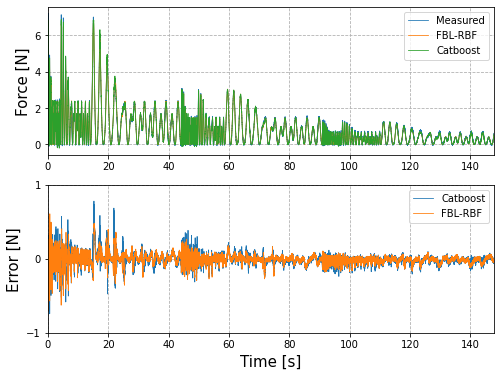

In [27]:
fig, (ax1, ax2) = plt.subplots(2, 1)
fig.set_figheight(6)
fig.set_figwidth(8)

ax1.grid(linestyle='--',linewidth=0.8)
ax1.plot(np.arange(0,148,0.001),y_test[:148000],label = 'Measured',linewidth=0.8)
ax1.plot(np.arange(0,148,0.001),y1[:148000],label = 'FBL-RBF',linewidth=0.8)
ax1.plot(np.arange(0,148,0.001),y2[:148000],label = 'Catboost',linewidth=0.8)
ax1.legend(loc = 'upper right')
ax1.set_xlim([0, 148])
ax1.set_ylabel('Force [N]',fontsize=15)
#ax1.set_xlabel('Time [s]',fontsize=15)

ax2.grid(linestyle='--',linewidth=0.8)
ax2.plot(np.arange(0,148,0.001),error_cat[:148000],label = 'Catboost',linewidth=0.8)
ax2.plot(np.arange(0,148,0.001),error_rbf[:148000],label = 'FBL-RBF',linewidth=0.8)
ax2.legend(loc = 'upper right')
ax2.set_xlim([0, 148])
ax2.set_ylim([-1, 1])
ax2.yaxis.set_major_locator(MaxNLocator(integer=True))
ax2.set_ylabel('Error [N]',fontsize=15)
ax2.set_xlabel('Time [s]',fontsize=15)
plt.savefig('obj5_def_9.eps')
plt.savefig('obj5_def_9.pdf')
plt.show()